### Read Events

In [1]:
from pathlib import Path
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import datetime

def read_tfevent_files_as_dataframe(log_dir):
    """
    Reads all tfevents files from a directory and extracts metrics into a single DataFrame.

    Args:
        log_dir (str): Directory containing tfevents files.

    Returns:
        pd.DataFrame: DataFrame containing 'metric_name', 'timestamp', 'step', and 'value'.
    """
    data = []
    log_dir = Path(log_dir)
    event_files = list(log_dir.glob('events.out.tfevents.*'))

    for file_path in event_files:
        try:
            event_acc = EventAccumulator(str(file_path))
            event_acc.Reload()
            available_tags = event_acc.Tags().get('scalars', [])

            for metric in available_tags:
                events = event_acc.Scalars(metric)
                for event in events:
                    # Convert wall_time to datetime
                    timestamp = datetime.datetime.fromtimestamp(event.wall_time)
                    data.append({
                        'metric_name': metric,
                        'timestamp': timestamp,
                        'step': event.step,
                        'value': event.value
                    })

        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            return  pd.DataFrame()

    # Create DataFrame
    df = pd.DataFrame(data)

    start_time = df['timestamp'].iloc[0]
    df['relative_time'] = (df['timestamp'] - start_time).dt.total_seconds() / 60  # Convert to minutes

    # Ensure sorting by metric_name and step for consistent plotting
    df = df.sort_values(by=['metric_name', 'step']).reset_index(drop=True)

    return df

# Get dataframe

In [2]:
df = read_tfevent_files_as_dataframe("exp_8/logs/DQN_0")

### Plot1

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_metric(df, metric_name, use_time=False, figsize=(8, 6), save_path=None, last_n_minutes=None,):
    """
    Visualize a specific metric using matplotlib. Option to display time or steps on the x-axis.

    Args:
        df (pd.DataFrame): DataFrame containing the metrics.
        metric_name (str): The metric to visualize (e.g., 'reward', 'loss').
        use_time (bool): If True, use timestamps on the x-axis. If False, use steps.
        figsize (tuple): The size of the figure.
        save_path (str, optional): If provided, saves the plot to the specified path.

    Returns:
        None
    """
    # Filter data for the selected metric
    metric_data = df[df['metric_name'] == metric_name]

    # Filter for the last n minutes if requested
    if last_n_minutes is not None:
        # Get the maximum relative time (latest timestamp)
        max_time = metric_data['relative_time'].max()

        # Filter to include only the last n minutes
        metric_data = metric_data[metric_data['relative_time'] >= (max_time - last_n_minutes)]

    # Set up the plot
    plt.figure(figsize=figsize)

    # Choose x-axis data: either timestamps or steps
    if use_time:
        plt.plot(metric_data['relative_time'], metric_data['value'], label=metric_name, color='tab:blue')
        plt.xlabel('Time (minutes)', fontsize=14)
    else:
        plt.plot(metric_data['step'], metric_data['value'], label=metric_name, color='tab:blue')

    # Adding labels and title
    plt.title(f"{metric_name.capitalize()} over Time" if use_time else f"{metric_name.capitalize()} over Steps", fontsize=16)
    plt.xlabel('Time' if use_time else 'Steps', fontsize=14)
    plt.ylabel(f'{metric_name.capitalize()}', fontsize=14)

    # Improve appearance
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # Optionally save the plot
    if save_path:
        plt.savefig(save_path, dpi=300)  # High resolution for paper publishing
    else:
        plt.show()


## Publication

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

def plot_metric_publication(df, metric_name, use_time=False, figsize=(8, 6), save_path=None, 
                          last_n_minutes=None, window_size=100, ci=0.95):
    """
    Create publication-quality visualizations of metrics with confidence intervals.
    
    Args:
        df (pd.DataFrame): DataFrame containing metrics data
        metric_name (str): Metric to visualize
        use_time (bool): Use timestamps (True) or steps (False) for x-axis
        figsize (tuple): Figure dimensions in inches
        save_path (str): Optional path to save figure
        last_n_minutes (float): Optional time window to display
        window_size (int): Size of rolling window for confidence interval calculation
        ci (float): Confidence interval (0 to 1)
    """
    # Set publication style
    plt.style.use("seaborn-v0_8-paper")
    sns.set_style("ticks")
    plt.rcParams.update({
        'font.family': 'serif',
        'font.size': 10,
        'axes.labelsize': 12,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.figsize': figsize,
        'figure.dpi': 300
    })

    # Filter and prepare data
    metric_data = df[df['metric_name'] == metric_name].copy()
    if last_n_minutes:
        max_time = metric_data['relative_time'].max()
        metric_data = metric_data[
            metric_data['relative_time'] >= (max_time - last_n_minutes)
        ]

    # Calculate rolling statistics
    x_data = metric_data['relative_time'] if use_time else metric_data['step']
    rolling_mean = metric_data['value'].rolling(window=window_size, center=True).mean()
    
    # Calculate confidence intervals
    z_score = stats.norm.ppf((1 + ci) / 2)
    rolling_std = metric_data['value'].rolling(window=window_size, center=True).std()
    ci_upper = rolling_mean + z_score * rolling_std / np.sqrt(window_size)
    ci_lower = rolling_mean - z_score * rolling_std / np.sqrt(window_size)

    # Create figure
    fig, ax = plt.subplots()
    
    # Plot confidence interval
    ax.fill_between(x_data, ci_lower, ci_upper, color='#1f77b4', alpha=0.2, 
                   label=f'{int(ci*100)}% Confidence Interval')
    
    # Plot mean line
    ax.plot(x_data, rolling_mean, color='#1f77b4', linewidth=1.5, 
           label=f'Rolling Mean (window={window_size})')

    # Configure axes
    ax.set_xlabel('Time (minutes)' if use_time else 'Training Steps', fontweight='bold')
    ax.set_ylabel(metric_name.replace('_', ' ').title(), fontweight='bold')
    
    # Add grid and legend
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()
    
    # Configure spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()

    # Save or display
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()

def plot_metric_publication2(df, metric_name, use_time=False, figsize=(8, 6), save_path=None, last_n_minutes=None):
    """
    Create publication-quality visualizations of metrics using matplotlib.
    
    Args:
        df (pd.DataFrame): DataFrame containing metrics data
        metric_name (str): Metric to visualize
        use_time (bool): Use timestamps (True) or steps (False) for x-axis
        figsize (tuple): Figure dimensions in inches
        save_path (str): Optional path to save figure
        last_n_minutes (float): Optional time window to display
    """
    # Set publication style
    # plt.style.use('seaborn-paper')
    plt.style.use("seaborn-v0_8-paper")
    sns.set_style("ticks")
    plt.rcParams.update({
        'font.family': 'serif',
        'font.size': 10,
        'axes.labelsize': 12,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.figsize': figsize,
        'figure.dpi': 300
    })

    # Filter and prepare data
    metric_data = df[df['metric_name'] == metric_name]
    if last_n_minutes:
        max_time = metric_data['relative_time'].max()
        metric_data = metric_data[
            metric_data['relative_time'] >= (max_time - last_n_minutes)
        ]

    # Create figure
    fig, ax = plt.subplots()
    
    # Plot data
    x_data = metric_data['relative_time'] if use_time else metric_data['step']
    ax.plot(x_data, metric_data['value'], color='#1f77b4', linewidth=1.5)

    # Configure axes
    ax.set_xlabel('Time (minutes)' if use_time else 'Training Steps', fontweight='bold')
    ax.set_ylabel(metric_name.replace('_', ' ').title(), fontweight='bold')
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Configure spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()

    # Save or display
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()

### Test out

In [4]:
df['metric_name'].value_counts()

metric_name
rollout/exploration_rate    26064
train/learning_rate         26047
train/loss                  26047
episode/bumpiness           25890
episode/holes               25890
episode/lines_cleared       25890
episode/pieces_placed       25890
episode/score               25890
eval/mean_ep_length         16005
eval/mean_reward            16005
rollout/ep_len_mean         10059
rollout/ep_rew_mean         10059
time/fps                    10059
Name: count, dtype: int64

In [31]:
#plot_metric_publication(df, 'train/loss', save_path="train_loss")
plot_metric_publication(df, 'episode/score', save_path="images/score")
plot_metric_publication(df, 'episode/pieces_placed', save_path="images/pieces_placed")
plot_metric_publication(df, 'episode/lines_cleared', save_path="images/lines_cleared")
plot_metric_publication(df, 'episode/holes', save_path="images/holes")
plot_metric_publication(df, 'episode/bumpiness', save_path="images/bumpiness")

plot_metric_publication(df, 'eval/mean_ep_length', save_path="images/mean_ep_length")
plot_metric_publication(df, 'rollout/ep_rew_mean', save_path="images/ep_rew_mean")

In [38]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

def plot_metric_publication(df, metric_name, use_time=False, figsize=(8, 6), save_path=None, 
                          last_n_minutes=None, window_size=100):
    """
    Create publication-quality visualizations of metrics with multiple confidence bands 
    and percentile ranges.
    
    Args:
        df (pd.DataFrame): DataFrame containing metrics data
        metric_name (str): Metric to visualize
        use_time (bool): Use timestamps (True) or steps (False) for x-axis
        figsize (tuple): Figure dimensions in inches
        save_path (str): Optional path to save figure
        last_n_minutes (float): Optional time window to display
        window_size (int): Size of rolling window for statistics calculation
    """
    # Set publication style
    plt.style.use("seaborn-v0_8-paper")
    sns.set_style("ticks")
    plt.rcParams.update({
        'font.family': 'serif',
        'font.size': 10,
        'axes.labelsize': 12,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.figsize': figsize,
        'figure.dpi': 300
    })

    # Filter and prepare data
    metric_data = df[df['metric_name'] == metric_name].copy()
    if last_n_minutes:
        max_time = metric_data['relative_time'].max()
        metric_data = metric_data[
            metric_data['relative_time'] >= (max_time - last_n_minutes)
        ]

    x_data = metric_data['relative_time'] if use_time else metric_data['step']
    
    # Calculate rolling statistics
    rolling_mean = metric_data['value'].rolling(window=window_size, center=True).mean()
    
    # Calculate percentiles for different ranges
    def rolling_percentile(q):
        return metric_data['value'].rolling(window=window_size, center=True).quantile(q)
    
    percentiles = {
        'p10': rolling_percentile(0.1),
        'p25': rolling_percentile(0.25),
        'p75': rolling_percentile(0.75),
        'p90': rolling_percentile(0.9),
    }

    # Create figure
    fig, ax = plt.subplots()
    
    # Plot percentile ranges
    ax.fill_between(x_data, percentiles['p10'], percentiles['p90'], 
                   color='#1f77b4', alpha=0.1, 
                   label='10th-90th Percentile')
    ax.fill_between(x_data, percentiles['p25'], percentiles['p75'], 
                   color='#1f77b4', alpha=0.2, 
                   label='25th-75th Percentile')
    
    # Plot mean line
    ax.plot(x_data, rolling_mean, color='#1f77b4', linewidth=1.5, 
           label=f'Rolling Mean (window={window_size})')

    # Configure axes
    ax.set_xlabel('Time (minutes)' if use_time else 'Training Steps', fontweight='bold')
    ax.set_ylabel(metric_name.replace('_', ' ').title(), fontweight='bold')
    
    # Add grid and legend
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper left')
    
    # Configure spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()

    # Save or display
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()

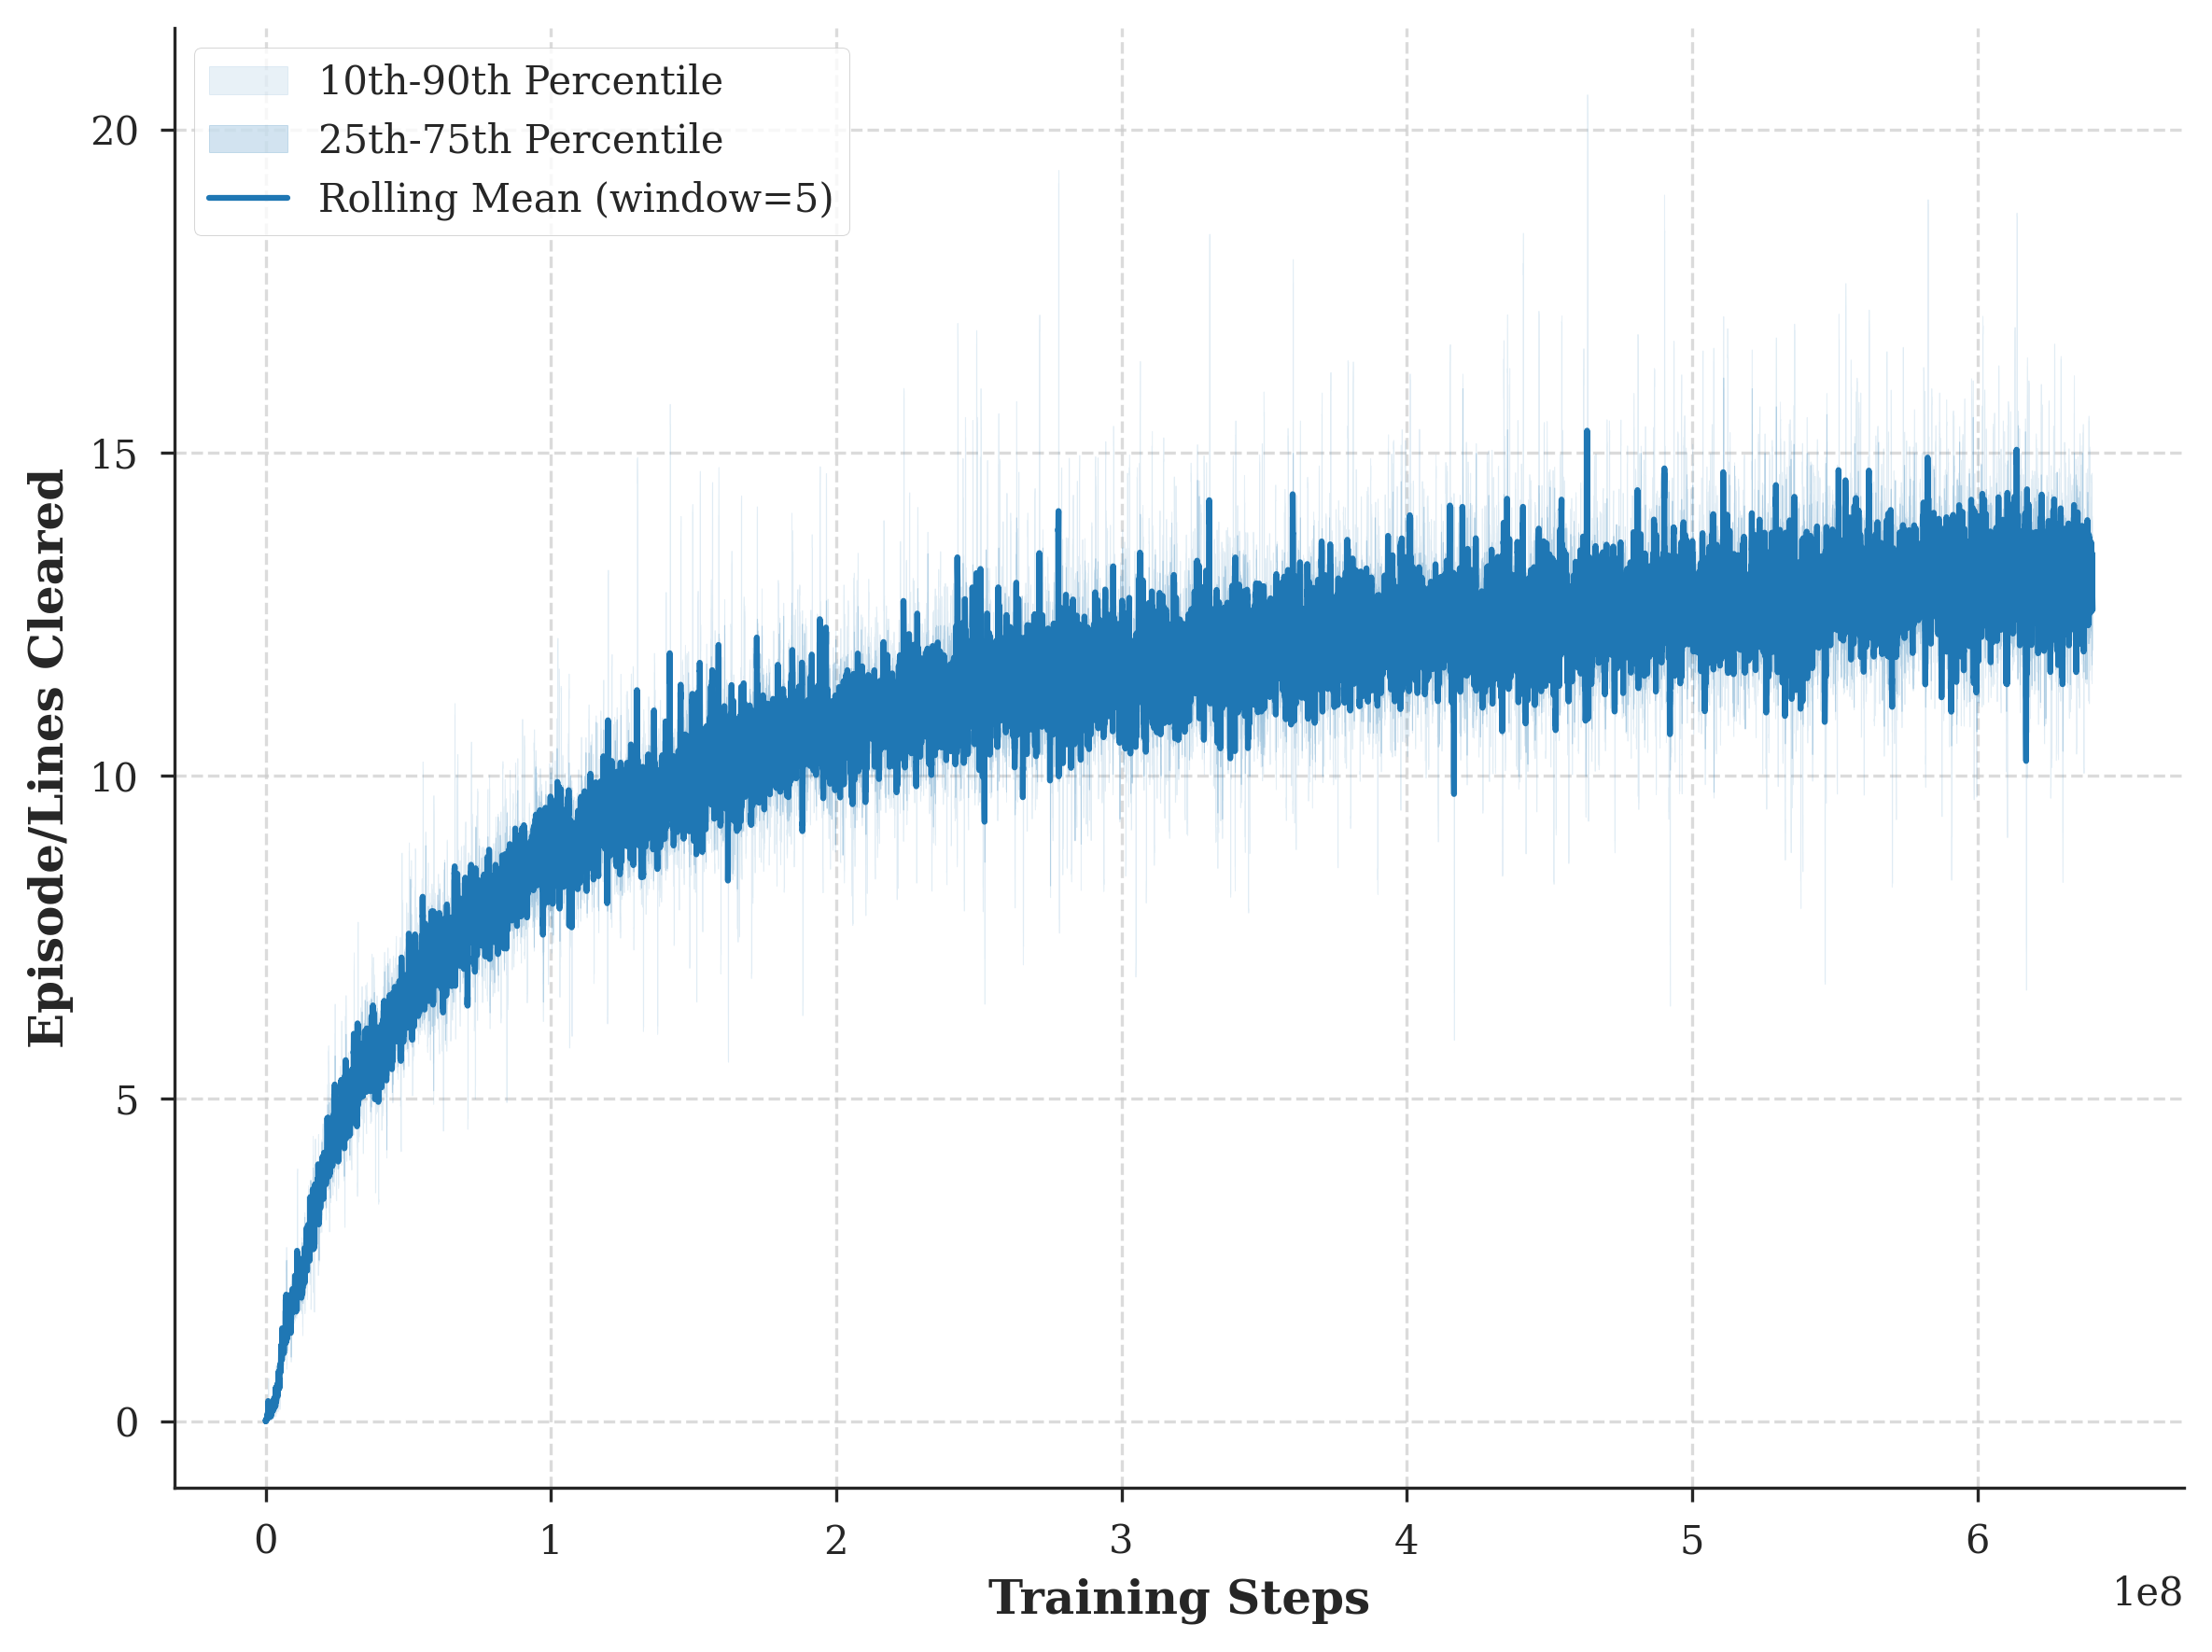

In [44]:
plot_metric_publication(df, 'episode/lines_cleared', window_size=5)


### Plot2

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metric_seaborn(df, metric_name, use_time=True, last_n_minutes=None, figsize=(8, 6), save_path=None):
    """
    Visualize a specific metric using Seaborn and Matplotlib. Option to display relative time (T+time) or steps on the x-axis.
    Can also zoom in on the last n minutes of data.

    Args:
        df (pd.DataFrame): DataFrame containing the metrics.
        metric_name (str): The metric to visualize (e.g., 'reward', 'loss').
        use_time (bool): If True, use timestamps on the x-axis as relative time (T+time). If False, use steps.
        last_n_minutes (int, optional): If specified, only display the last n minutes of data.
        figsize (tuple): The size of the figure.
        save_path (str, optional): If provided, saves the plot to the specified path.

    Returns:
        None
    """
    # Set Seaborn style
    sns.set(style="whitegrid", palette="muted", font_scale=1.3)

    # Filter data for the selected metric
    metric_data = df[df['metric_name'] == metric_name]

    # Filter for the last n minutes if requested
    if last_n_minutes is not None:
        # Get the maximum relative time (latest timestamp)
        max_time = metric_data['relative_time'].max()

        # Filter to include only the last n minutes
        metric_data = metric_data[metric_data['relative_time'] >= (max_time - last_n_minutes)]

    # Set up the plot
    plt.figure(figsize=figsize)

    # Choose x-axis data: either relative time (T+time) or steps
    if use_time:
        sns.lineplot(x='relative_time', y='value', data=metric_data, label=metric_name, color='tab:blue')
        plt.xlabel('Time (minutes)', fontsize=14)
    else:
        sns.lineplot(x='step', y='value', data=metric_data, label=metric_name, color='tab:blue')
        plt.xlabel('Steps', fontsize=14)

    # Adding labels and title
    plt.title(f"{metric_name.capitalize()} over Time" if use_time else f"{metric_name.capitalize()} over Steps", fontsize=16)
    plt.ylabel(f'{metric_name.capitalize()}', fontsize=14)

    # Optionally save the plot
    if save_path:
        plt.savefig(save_path, dpi=300)  # High resolution for paper publishing
    else:
        plt.show()

### Use the plot

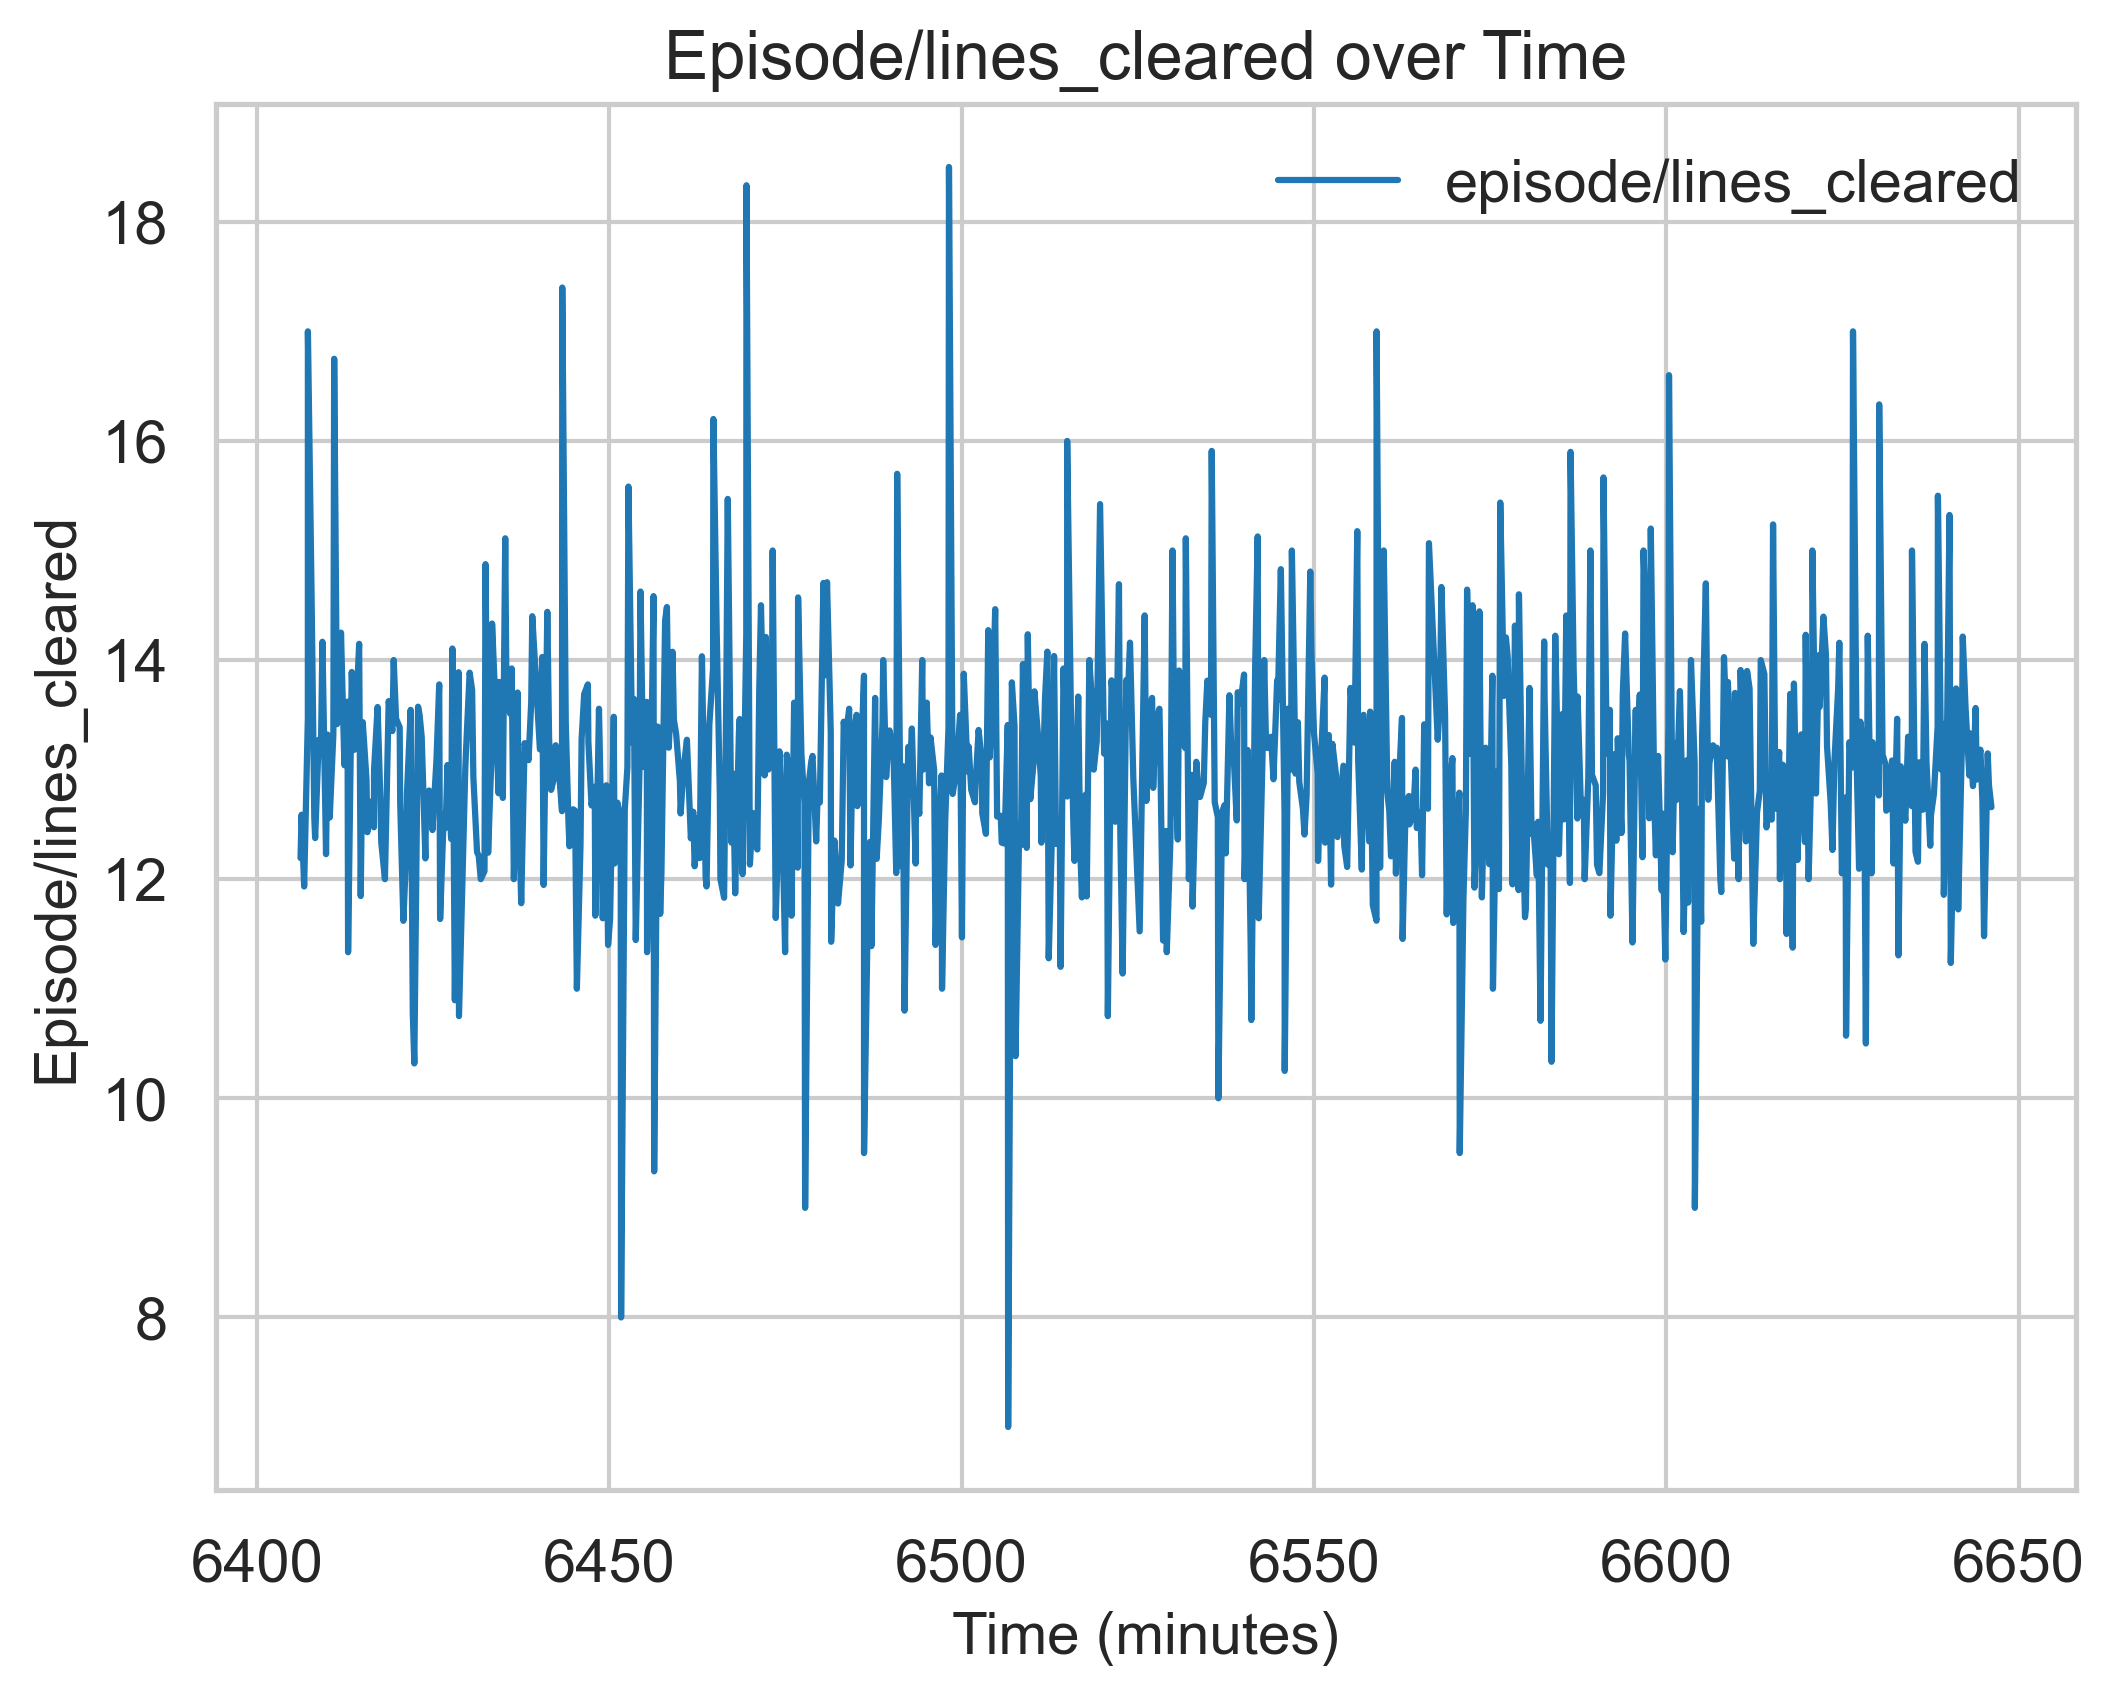

In [32]:
plot_metric_seaborn(df, 'episode/lines_cleared', use_time=True, last_n_minutes=240)

### Plot3

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

def plot_metric_seaborn2(df, metric_name, use_time=True, last_n_minutes=None, smoothing='rolling', window_size=5, figsize=(8, 6), save_path=None):
    """
    Visualize a specific metric using Seaborn and Matplotlib. Option to display relative time (T+time) or steps on the x-axis.
    Can also zoom in on the last n minutes of data. Optionally apply smoothing to the data.

    Args:
        df (pd.DataFrame): DataFrame containing the metrics.
        metric_name (str): The metric to visualize (e.g., 'reward', 'loss').
        use_time (bool): If True, use timestamps on the x-axis as relative time (T+time). If False, use steps.
        last_n_minutes (int, optional): If specified, only display the last n minutes of data.
        smoothing (str): Type of smoothing to apply. Options are 'rolling', 'EMA', 'savgol'.
        window_size (int): The window size for smoothing (e.g., 5, 10, etc.).
        figsize (tuple): The size of the figure.
        save_path (str, optional): If provided, saves the plot to the specified path.

    Returns:
        None
    """
    # Set Seaborn style
    sns.set(style="whitegrid", palette="muted", font_scale=1.3)

    # Filter data for the selected metric
    metric_data = df[df['metric_name'] == metric_name]

    # Filter for the last n minutes if requested
    if last_n_minutes is not None:
        # Get the maximum relative time (latest timestamp)
        max_time = metric_data['relative_time'].max()

        # Filter to include only the last n minutes
        metric_data = metric_data[metric_data['relative_time'] >= (max_time - last_n_minutes)]

    # Apply smoothing based on the specified method
    if smoothing == 'rolling':
        metric_data['smoothed'] = metric_data['value'].rolling(window=window_size, min_periods=1).mean()
    elif smoothing == 'EMA':
        metric_data['smoothed'] = metric_data['value'].ewm(span=window_size, adjust=False).mean()
    elif smoothing == 'savgol':
        metric_data['smoothed'] = savgol_filter(metric_data['value'], window_length=window_size, polyorder=2)

    # Set up the plot
    plt.figure(figsize=figsize)

    # Choose x-axis data: either relative time (T+time) or steps
    if use_time:
        # sns.lineplot(x='relative_time', y='value', data=metric_data, label=f'{metric_name} (raw)', color='tab:blue')
        sns.lineplot(x='relative_time', y='smoothed', data=metric_data, label=f'{metric_name} (smoothed)', color='tab:orange')
        plt.xlabel('Time (minutes)', fontsize=14)
    else:
        # sns.lineplot(x='step', y='value', data=metric_data, label=f'{metric_name} (raw)', color='tab:blue')
        sns.lineplot(x='step', y='smoothed', data=metric_data, label=f'{metric_name} (smoothed)', color='tab:orange')
        plt.xlabel('Steps', fontsize=14)

    # Adding labels and title
    plt.title(f"{metric_name.capitalize()} over Time" if use_time else f"{metric_name.capitalize()} over Steps", fontsize=16)
    plt.ylabel(f'{metric_name.capitalize()}', fontsize=14)

    # Show legend
    plt.legend()

    # Optionally save the plot
    if save_path:
        plt.savefig(save_path, dpi=300)  # High resolution for paper publishing
    else:
        plt.show()


### Use plot3

/tmp/ipykernel_1736214/4121376731.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_data['smoothed'] = metric_data['value'].ewm(span=window_size, adjust=False).mean()


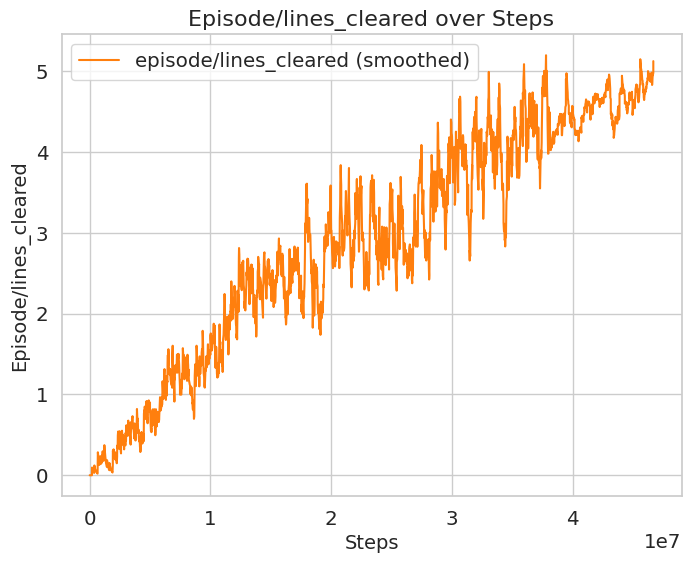

In [91]:
# plot_metric_seaborn2(df, 'episode/pieces_placed', use_time=False, last_n_minutes=None, smoothing="EMA", window_size=20)
# plot_metric_seaborn2(df, 'episode/score', use_time=False, last_n_minutes=None, smoothing="EMA", window_size=20)
plot_metric_seaborn2(df, 'episode/lines_cleared', use_time=False, last_n_minutes=None, smoothing="EMA", window_size=20)

In [40]:
df[df['metric_name'] == 'episode/lines_cleared']

,metric_name,timestamp,step,value,relative_time
51780,episode/lines_cleared,2024-11-19 20:58:37.743660,4732,0.000000,-412.451144
51781,episode/lines_cleared,2024-11-19 20:58:38.044044,9136,0.000000,-412.446137
51782,episode/lines_cleared,2024-11-19 20:58:38.348948,13648,0.000000,-412.441055
51783,episode/lines_cleared,2024-11-19 20:58:38.654662,18112,0.000000,-412.435960
51784,episode/lines_cleared,2024-11-19 20:58:38.946906,22424,0.000000,-412.431089
...,...,...,...,...,...
77665,episode/lines_cleared,2024-11-24 18:35:57.359943,640346176,12.705882,6644.875794
77666,episode/lines_cleared,2024-11-24 18:36:11.167374,640362244,11.480000,6645.105918
77667,episode/lines_cleared,2024-11-24 18:36:42.489679,640402244,13.148149,6645.627957
77668,episode/lines_cleared,2024-11-24 18:36:52.971338,640416628,12.857142,6645.802651
